In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from ml_helpers import *

In [2]:
def awgn(signal, SNR, measured=False, return_true_snr=False):
    
    if measured:
        # Measure signal power 
        s_p = np.mean(abs(signal)**2)
    else:
        s_p = 1
    
    # Calculate noise power
    n_p = s_p/(10 **(SNR/10))
    
    # Generate complex noise
    noise = np.sqrt(n_p/2)*(np.random.randn(*signal.shape) + \
                                np.random.randn(*signal.shape)*1j)
    
    # Add signal and noise 
    signal_noisy = signal + noise 
    
    if not return_true_snr:
        return signal_noisy
    else:
        return signal_noisy, s_p/(np.mean(abs(noise)**2))
    
def pulse_shape(symbols, sps=5):
    num_weights = 251
    x = np.arange(-int(num_weights/2),int(num_weights/2)+1,1)/sps
    sinc_weights = np.sinc(x)
    
    padded_symbols = np.zeros(len(symbols)*sps, dtype=complex)
    padded_symbols[np.arange(0,len(padded_symbols),sps)] = symbols
    
    return np.convolve(padded_symbols, sinc_weights, mode='same')

In [3]:
# Function to generate BPSK
def generate_bpsk(num_symbols, noise=50):
    bits = np.random.randint(0,2,num_symbols)
    bpsk_scheme = [1+0j, -1+0j]
    bpsk_symbols = np.array([bpsk_scheme[i] for i in bits])
    
    bpsk_symbols = awgn(bpsk_symbols, noise)
    
    return bpsk_symbols

# Function to generate QPSK
def generate_qpsk(num_symbols, noise=50):
    qpsk_scheme= [1+1j, 1-1j, -1+1j, -1-1j]
    ints = np.random.randint(0,4,num_symbols)
    qpsk_symbols = np.array([qpsk_scheme[i] for i in ints])/np.sqrt(2)
    
    return qpsk_symbols

# Function to generate QAM
def generate_qam(num_symbols, noise=50):
    qam_scheme = [-3-3j, -3-1j, -3+3j, -3+1j,  \
                  -1-3j, -1-1j, -1+3j, -1+1j,  \
                   3-3j,  3-1j,  3+3j,  3+1j,  \
                   1-3j,  1-1j,  1+3j,  1+1j]
    ints = np.random.randint(0,16,num_symbols)
    qam_symbols = np.array([qam_scheme[i] for i in ints])
    qam_symbols = qam_symbols/np.mean(np.abs(qam_scheme))
    
    return qam_symbols

# Function to generate 4-ASK
def generate_ask4(num_symbols, noise=50):
    ask4_scheme = [3+0j, 1+0j, -1+0j, -3+0j]
    ints = np.random.randint(0,4,num_symbols)
    ask4_symbols = np.array([ask4_scheme[i] for i in ints])
    ask4_symbols = ask4_symbols/np.mean(np.abs(ask4_scheme))
    
    return ask4_symbols

# Function to generate 8-PSK
def generate_psk8(num_symbols, noise=50):
    psk8_scheme = [ 1+0j, 0.7071+0.7071j, 0+1j, -0.7071+0.7071j, \
                   -1+0j, -0.7071-0.7071j, 0-1j, 0.7071-0.7071j]
    
    ints = np.random.randint(0,8,num_symbols)
    psk8_symbols = np.array([psk8_scheme[i] for i in ints])
    psk8_symbols = psk8_symbols/np.mean(np.abs(psk8_scheme))
    
    return psk8_symbols

In [4]:
def gen_tensor_data(mod_scheme, num_frames=32, samples_per_frame=128, sps=5, snr=30):
            
    symbols_required = int(np.ceil(samples_per_frame/sps))*num_frames
        
    # Mod scheme has to be one of: 'BPSK', 'QPSK', '16-QAM'
    if mod_scheme == 'BPSK':
        symbols = pulse_shape(generate_bpsk(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == 'QPSK':
        symbols = pulse_shape(generate_qpsk(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '8-PSK':
        symbols = pulse_shape(generate_psk8(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '16-QAM':
        symbols = pulse_shape(generate_qam(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '4-ASK':
        symbols = pulse_shape(generate_ask4(symbols_required), sps=sps)[:num_frames*samples_per_frame]

    # Add noise and split into frames
    frames, sn = awgn(symbols.reshape(num_frames,-1), snr, measured=True, return_true_snr=True)

    # Normalize to unit energy per frame
    for i, frame in enumerate(frames):
        power = np.mean((np.abs(frame)))
        frames[i] = frame / power

    # Split into I/Q, add extra channel to make a 4-D tensor
    return torch.FloatTensor(np.stack((frames.real, frames.imag),axis=1)), sn

In [5]:
def gen_data_from_list(mod_scheme, snr_range, num_frames=32, samples_per_frame=128, return_db=False):
    
    # total dataset size
    frames = torch.zeros((num_frames*len(snr_range), 2, samples_per_frame), dtype=torch.float)
    
    # snrs dataset for multitask
    snrs = torch.zeros(num_frames*len(snr_range), dtype=torch.float)
    
    for i, snr in enumerate(snr_range):
        frames[i*num_frames:(i+1)*num_frames], sn = gen_tensor_data(mod_scheme, num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
        if return_db:
            snrs[i*num_frames:(i+1)*num_frames] = snr
        else:
            snrs[i*num_frames:(i+1)*num_frames] = sn
    
    return frames, snrs

In [6]:
# Function returns a torch dataloader with specified batch_size and num_frames
# number of examples per snr level
def gen_loader(num_frames=32, samples_per_frame=1024, snr=[30], batch_size=32, case=1, return_db=False):
    
    if case == 1 or case == 2:
        return_db=True
    
    # Generate the individual waveforms for each modulation scheme
    bpsk_data, bpsk_snrs = gen_data_from_list('BPSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame, return_db=return_db)
    qpsk_data, qpsk_snrs = gen_data_from_list('QPSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame, return_db=return_db)
    psk_data, psk_snrs = gen_data_from_list('8-PSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame, return_db=return_db)
    qam_data, qam_snrs = gen_data_from_list('16-QAM', snr, num_frames=num_frames, samples_per_frame=samples_per_frame, return_db=return_db)
    ask_data, ask_snrs = gen_data_from_list('4-ASK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame, return_db=return_db)
    
    # Concat them into a single training data tensor
    train_data = torch.cat((bpsk_data, qpsk_data, psk_data, qam_data, ask_data))
    
    # Create class labels
    bpsk_labels = torch.zeros(bpsk_data.shape[0])
    qpsk_labels = torch.ones(qpsk_data.shape[0])
    psk_labels = torch.ones(psk_data.shape[0])*2
    qam_labels = torch.ones(qam_data.shape[0])*3
    ask_labels = torch.ones(ask_data.shape[0])*4

    # Concat class labels
    # We will be using cross entropy loss, which expects a long tensor as the label hence the .long() here
    train_labels = torch.cat((bpsk_labels, qpsk_labels, psk_labels, qam_labels, ask_labels)).long()
    
    # SNR labels
    snr_labels = torch.cat((bpsk_snrs, qpsk_snrs, psk_snrs, qam_snrs, ask_snrs))
    
    if case == 0 or case == 1: 
#         snr_labels[snr_labels > 10] = 10
        train_labels_snr = snr_labels # case 0 returns linear snrs, case 1 returns dBs
    elif case == 2:
        snr_db_labels = snr_labels.numpy().astype(int)
        train_snr_range = np.arange(-15,16,2, dtype=int)
        snr_indexes = {index:value for index, value in zip(train_snr_range, np.arange(len(train_snr_range)))}
        train_labels_snr = torch.tensor(list(map(lambda label: snr_indexes[label], snr_db_labels)), dtype=int)
    
    # if gpu
    train_data = train_data.cuda()
    train_labels = train_labels.cuda()
    train_labels_snr = train_labels_snr.cuda()
    
    # Create a Torch dataset
    train_dataset = torch.utils.data.TensorDataset(train_data, train_labels, train_labels_snr)
    
    return torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [7]:
train_snr_range = np.arange(-15,16,2)

In [8]:
loader = gen_loader(snr=train_snr_range, case=2)

In [9]:
x,y,z = next(iter(loader))

In [10]:
train_snr_range

array([-15, -13, -11,  -9,  -7,  -5,  -3,  -1,   1,   3,   5,   7,   9,
        11,  13,  15])

In [11]:
z

tensor([10,  1,  8, 15, 12,  8,  8, 11, 15,  2,  0, 14,  4, 13, 14,  4,  7,  6,
         0,  6, 12,  8, 10, 12, 13,  2, 15, 14, 15,  4,  3,  9],
       device='cuda:0')

In [12]:
train_snr_range[z.cpu().detach().numpy()]

array([  5, -13,   1,  15,   9,   1,   1,   7,  15, -11, -15,  13,  -7,
        11,  13,  -7,  -1,  -3, -15,  -3,   9,   1,   5,   9,  11, -11,
        15,  13,  15,  -7,  -9,   3])

## Baseline m2m4

In [14]:
snr_estims = []
sns = []

snr_range = np.arange(-10,11)

for snr in snr_range:
    x, sn = gen_tensor_data('QPSK', num_frames=2, samples_per_frame=1024, sps=1, snr=snr)
    x = x[0].numpy()
    x_c = x[0] + x[1]*1j

    m2 = (np.sum(np.abs(x_c**2)))/len(x_c)
    m4 = (np.sum(np.abs(x_c**4)))/len(x_c)

    snr_estim = np.sqrt(np.abs(2*(m2**2)-m4))/(m2 - np.sqrt(np.abs(2*(m2**2)-m4)))
    
    snr_estims.append(snr_estim)
    sns.append(sn)

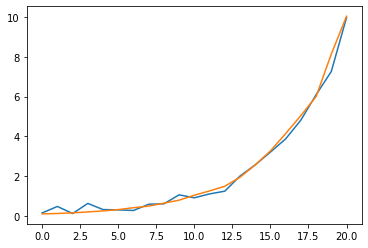

In [15]:
plt.plot(np.array(snr_estims))
plt.plot(np.array(sns))

In [19]:
estims, sns_list = [], []
mods = ['BPSK', 'QPSK', '8-PSK', '16-QAM']
snr_range = np.arange(-15,16)
num_iter = 500

for snr in snr_range:
    k_estim, k_db, sns = 0, 0, 0
    for _ in range(num_iter):
        x, sn = gen_tensor_data(mods[np.random.randint(low=0, high=4)], num_frames=2, samples_per_frame=1024, sps=1, snr=snr)
#         x, sn = gen_tensor_data('QPSK', num_frames=2, samples_per_frame=1024, sps=1, snr=snr)
        x = x[0].numpy()
        x_c = x[0] + x[1]*1j
#         m2 = np.abs(np.mean(x_c*np.conj(x_c)))
#         m4 = np.abs(np.mean((x_c*np.conj(x_c))**2))
        m2 = (np.sum(np.abs(x_c**2)))/len(x_c)
        m4 = (np.sum(np.abs(x_c**4)))/len(x_c)
#         beta = m4 / (m2 - m4)
#         k_estim = beta - 1 + np.sqrt(beta*(beta-1))
        k_estim += np.sqrt(np.abs(2*(m2**2)-m4))/(m2 - np.sqrt(np.abs(2*(m2**2)-m4)))
        sns += sn
    estims.append(k_estim/num_iter)
    sns_list.append(sns/num_iter)
estims = np.array(estims)
sns_list = np.array(sns_list)

In [20]:
snr_range

array([-15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,
        -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
        11,  12,  13,  14,  15])

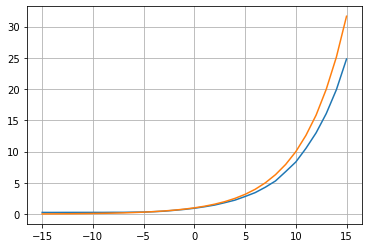

In [21]:
plt.plot(snr_range, estims)
plt.plot(snr_range, sns_list)
# plt.plot(snr_range, 10**(snr_range/10))
# plt.plot(snr_range, 1/(1/(10**(snr_range/10))))
# plt.ylim([0,1])
plt.grid()

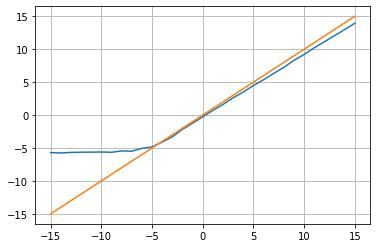

In [22]:
plt.plot(snr_range, 10*np.log10(estims))
plt.plot(snr_range, snr_range)
plt.grid()

In [23]:
m2m4_baseline = {'snr_range': snr_range,
                 'snr_estims': estims}

In [25]:
torch.save(m2m4_baseline, 'baselines/m2m4_snr_estimation.pt')
# torch.load('baselines/m2m4_snr_estimation.pt')

In [26]:
class snr_estimator(nn.Module):
    def __init__(self, num_outputs=1, relu_output=True):
        super(snr_estimator, self).__init__()
        
        self.convolutions = nn.Sequential(
                    nn.Conv1d(2, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU()
                    )
        
        if relu_output:
            self.noise_estimator = nn.Sequential(
                                        nn.Linear(8192,512),
                                        nn.ReLU(),
                                        nn.Linear(512,64),
                                        nn.ReLU(),
                                        nn.Linear(64,num_outputs),
                                        nn.ReLU())
        else:
            self.noise_estimator = nn.Sequential(
                                        nn.Linear(8192,512),
                                        nn.ReLU(),
                                        nn.Linear(512,64),
                                        nn.ReLU(),
                                        nn.Linear(64,num_outputs))
        
    def forward(self, x):
        
        x = self.convolutions(x)
        
        x = torch.flatten(x,1)
        
        x = self.noise_estimator(x).squeeze()
        
        return x

In [27]:
def train(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=5, verbose=False):
    losses, val_losses = [], []
    best_loss = np.inf
    
    for epoch in range(num_epochs):
        running_loss = 0
        
        for x,y,z in train_loader:
            optimizer.zero_grad()
            
            z_hat = model(x)
            
            loss = loss_fn(z_hat,z)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        losses.append(running_loss/len(train_loader))
        
        with torch.no_grad():
            running_val_loss = 0
            for x,y,z in val_loader:
                z_hat = model(x)
                
                val_loss = loss_fn(z_hat, z)
                running_val_loss += val_loss.item()
            val_losses.append(running_val_loss/len(val_loader))
        
        if val_losses[-1] < best_loss:
            print(f'val_losses[-1] = {val_losses[-1]}, best_loss = {best_loss}, model saved at {epoch}')
            saved_model = model.state_dict()
            best_loss = val_losses[-1]
            
        
        if verbose:
            print(f"Loss: {losses[-1]}, Val loss: {val_losses[-1]}")
            
    model.load_state_dict(saved_model)
    
    return model, losses, val_losses

## Cross-entropy learning

In [28]:
model = snr_estimator(num_outputs=16, relu_output=False)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

train_snr_range = np.arange(-15,16,2)

train_loader = gen_loader(num_frames=128, snr=train_snr_range, batch_size=32, case=2)
val_loader = gen_loader(num_frames=32, snr=train_snr_range, batch_size=32, case=2)

num_epochs = 30
loss_fn = nn.CrossEntropyLoss()

In [29]:
model, losses, val_losses = train(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=num_epochs)

val_losses[-1] = 0.9102186754345893, best_loss = inf, model saved at 0
val_losses[-1] = 0.6204130370169878, best_loss = 0.9102186754345893, model saved at 1
val_losses[-1] = 0.3914478629827499, best_loss = 0.6204130370169878, model saved at 3
val_losses[-1] = 0.38952853828668593, best_loss = 0.3914478629827499, model saved at 7
val_losses[-1] = 0.32672252859920264, best_loss = 0.38952853828668593, model saved at 8
val_losses[-1] = 0.305023302603513, best_loss = 0.32672252859920264, model saved at 17
val_losses[-1] = 0.28475901996716857, best_loss = 0.305023302603513, model saved at 24


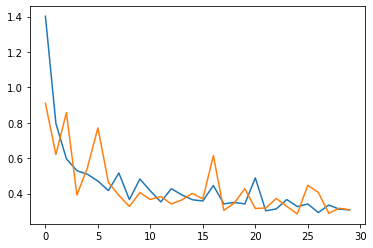

In [30]:
plt.plot(losses)
plt.plot(val_losses)
# plt.ylim([0,2])

In [31]:
val_loader = gen_loader(num_frames=32, snr=[5], batch_size=32, case=2)

x,y,z = next(iter(val_loader))

y_hat = model(x).cpu().detach()
y_hat.argmax(axis=1)

tensor([10, 10, 10, 10, 10, 10, 10,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

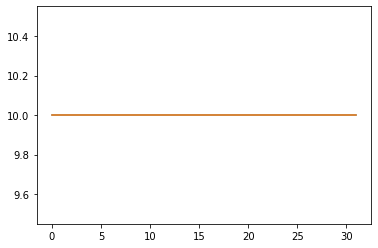

In [32]:
x,y,z = next(iter(val_loader))

y_hat = model(x).cpu().detach()
plt.plot(y_hat.argmax(axis=1))
plt.plot(z.cpu().detach())

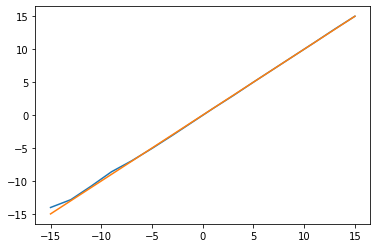

In [33]:
snr_range = train_snr_range
# snr_range = np.arange(-15,16,2)

z_hats = np.zeros(len(snr_range),)
for i, snr in enumerate(snr_range):
    z_hat_db = 0
    test_loader = gen_loader(num_frames=32, snr=[snr], batch_size=32, case=2)
    for x,y,z in test_loader:
        z_hat = model(x).argmax(axis=1)
        z_hat_db += torch.tensor(train_snr_range[z_hat.cpu().detach()])#10*torch.log10(z_hat)
    z_hats[i] = torch.sum(z_hat_db)/len(test_loader)/32
    
plt.plot(snr_range, z_hats)
plt.plot(snr_range, snr_range)

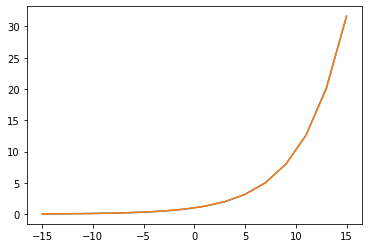

In [34]:
plt.plot(snr_range, 10**(z_hats/10))
plt.plot(snr_range, 10**(snr_range/10))

## MSE Learning, linear SNR

In [35]:
model = snr_estimator()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

train_snr = np.arange(-15,16,2)

train_loader = gen_loader(num_frames=64, snr=train_snr, batch_size=32, case=0)
val_loader = gen_loader(num_frames=32, snr=train_snr, batch_size=32, case=0)

num_epochs = 30
loss_fn = nn.MSELoss()

In [36]:
model, losses, val_losses = train(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=num_epochs)

val_losses[-1] = 3.0701666668057443, best_loss = inf, model saved at 0
val_losses[-1] = 1.8888573423027992, best_loss = 3.0701666668057443, model saved at 1
val_losses[-1] = 1.657745274528861, best_loss = 1.8888573423027992, model saved at 4
val_losses[-1] = 1.1014340145513415, best_loss = 1.657745274528861, model saved at 6
val_losses[-1] = 0.9735167630016803, best_loss = 1.1014340145513415, model saved at 7
val_losses[-1] = 0.6596763742156326, best_loss = 0.9735167630016803, model saved at 10
val_losses[-1] = 0.6235711729153991, best_loss = 0.6596763742156326, model saved at 11
val_losses[-1] = 0.5656566778197885, best_loss = 0.6235711729153991, model saved at 13
val_losses[-1] = 0.5295192076358944, best_loss = 0.5656566778197885, model saved at 20
val_losses[-1] = 0.5173534233123064, best_loss = 0.5295192076358944, model saved at 21
val_losses[-1] = 0.5079363497439772, best_loss = 0.5173534233123064, model saved at 24
val_losses[-1] = 0.4539529192727059, best_loss = 0.50793634974397

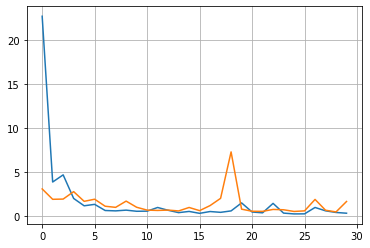

In [37]:
plt.plot(losses)
plt.plot(val_losses)
# plt.ylim([0.25,2])
plt.grid()

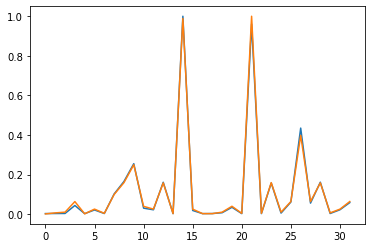

In [38]:
x,y,z = next(iter(val_loader))

y_hat = model(x).cpu().detach()
plt.plot(y_hat/torch.max(y_hat))
plt.plot(z.cpu().detach()/torch.max(z.cpu().detach()))

In [39]:
snr_range = np.arange(-15,16)

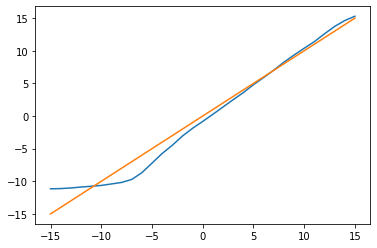

In [40]:
z_hats = np.zeros(len(snr_range),)
for i, snr in enumerate(snr_range):
    z_hat_db = 0
    test_loader = gen_loader(num_frames=64, snr=[snr], batch_size=32, case=0)
    for x,y,z in test_loader:
        z_hat = model(x)
        z_hat_db += 10*torch.log10(z_hat)
    z_hats[i] = torch.sum(z_hat_db)/len(test_loader)/32
    
plt.plot(snr_range, z_hats)
plt.plot(snr_range, snr_range)

(0.0, 1.0)

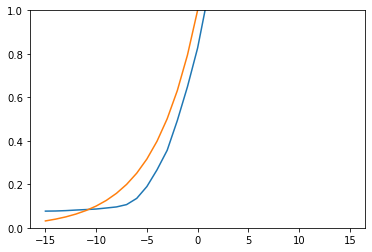

In [41]:
plt.plot(snr_range, 10**(z_hats/10))
plt.plot(snr_range, 10**(snr_range/10))
plt.ylim([0,1])

## MSE Learning, log SNR

In [42]:
model = snr_estimator(relu_output=False)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

train_snr = np.arange(-15,16,2)

train_loader = gen_loader(num_frames=64, snr=train_snr_range, batch_size=32, case=1)
val_loader = gen_loader(num_frames=32, snr=train_snr_range, batch_size=32, case=1)

num_epochs = 30
loss_fn = nn.MSELoss()

In [43]:
model, losses, val_losses = train(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=num_epochs)

val_losses[-1] = 1.0188261441886426, best_loss = inf, model saved at 0
val_losses[-1] = 0.8416171399876475, best_loss = 1.0188261441886426, model saved at 1
val_losses[-1] = 0.7317259900271893, best_loss = 0.8416171399876475, model saved at 6
val_losses[-1] = 0.6147704347968102, best_loss = 0.7317259900271893, model saved at 7


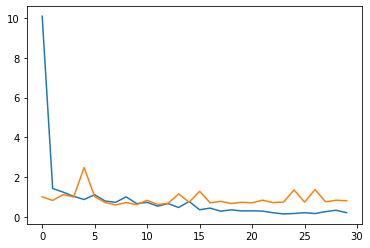

In [44]:
plt.plot(losses)
plt.plot(val_losses)
# plt.ylim([0,2])

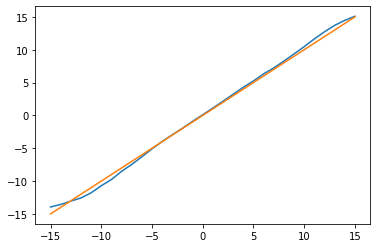

In [45]:
z_hats = np.zeros(len(snr_range),)
for i, snr in enumerate(snr_range):
    z_hat_db = 0
    test_loader = gen_loader(num_frames=64, snr=[snr], batch_size=32, case=1)
    for x,y,z in test_loader:
        z_hat_db += model(x)
#         z_hat_db += 10*torch.log10(z_hat)
    z_hats[i] = torch.sum(z_hat_db)/len(test_loader)/32
    
plt.plot(snr_range, z_hats)
plt.plot(snr_range, snr_range)

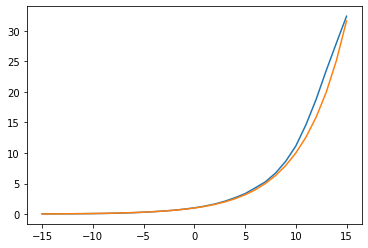

In [46]:
plt.plot(snr_range, 10**(z_hats/10))
plt.plot(snr_range, 10**(snr_range/10))